## Project: Hacker News Pipeline
In this course, we began with the concepts of functional programming, and then built our own data pipeline class in Python. We learned about advanced Python concepts such as the decorators, closures, and good API design. In the last lesson, we also learned how to implement a directed acyclic graph as the scheduler for our pipeline.

After completing all these lessons, we have finally built a robust data pipeline that schedules our tasks in the correct order! In this guided project, we will use the pipeline we have been building, and apply it to a real world data pipeline project. From a JSON API, we will filter, clean, aggregate, and summarize data in a sequence of tasks that will apply these transformations for us.

The data we will use comes from a Hacker News (HN) API that returns JSON data of the top stories in 2014. If you're unfamiliar with Hacker News, it's a link aggregator website that users vote up stories that are interesting to the community. It is similar to Reddit, but the community only revolves around on computer science and entrepreneurship posts.

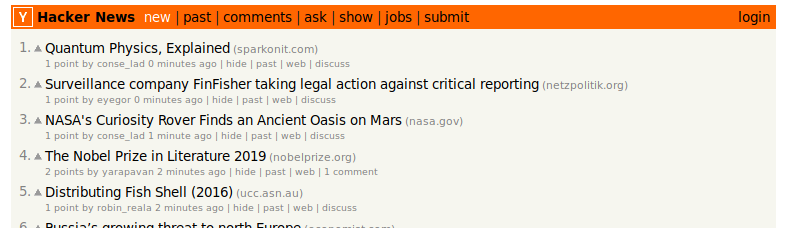

Source: https://dq-content.s3.amazonaws.com/267/hn.png

To make things easier, we have already downloaded a list of JSON posts to a file called hn_stories_2014.json. The JSON file contains a single key stories, which contains a list of stories (posts). Each post has a set of keys, but we will deal only with the following keys:

- created_at: A timestamp of the story's creation time.
- created_at_i: A unix epoch timestamp.
- url: The URL of the story link.
- objectID: The ID of the story.
- author: The story's author (username on HN).
- points: The number of upvotes the story had.
- title: The headline of the post.
- num_comments: The number of a comments a post has.

Here's an example of the full list of keys in a story:

{
    "story_text": "",
    "created_at": "2014-05-29T08:23:46Z",
    "story_title": null,
    "story_id": null,
    "comment_text": null,
    "created_at_i": 1401351826,
    "url": "http://bits.blogs.nytimes.com/2014/05/28/making-twitter-easier-to-use/",
    "parent_id": null,
    "objectID": "7815285",
    "author": "Leynos",
    "points": 1,
    "title": "Making Twitter Easier to Use",
    "_tags": [
        "story",
        "author_Leynos",
        "story_7815285"
    ],
    "num_comments": 0,
    "_highlightResult": {
        "story_text": {
            "matchedWords": [],
            "value": "",
            "matchLevel": "none"
        },
        "author": {
            "matchedWords": [],
            "value": "Leynos",
            "matchLevel": "none"
        },
        "url": {
            "matchedWords": [],
            "value": "http://bits.blogs.nytimes.com/2014/05/28/making-twitter-easier-to-use/",
            "matchLevel": "none"
        },
        "title": {
            "matchedWords": [],
            "value": "Making Twitter Easier to Use",
            "matchLevel": "none"
        }
    },
    "story_url": null
}

Using this dataset, we will run a sequence of basic natural language processing tasks using our Pipeline class. The goal will be to find the top 100 keywords of Hacker News posts in 2014. Because Hacker News is the most popular technology social media site, this will give us an understanding of the most talked about tech topics in 2014!

In [8]:
from datetime import datetime
import json
import io
import csv
import string

from pipeline import build_csv, Pipeline
from stop_words import stop_words

Here's an example of the full list of keys in a story:

In [9]:
pipeline = Pipeline()

@pipeline.task()
def file_to_json():
    with open('hn_stories_2014.json', 'r') as f:
        data = json.load(f)
        stories = data["stories"]
    return stories

@pipeline.task(depends_on = file_to_json)
def filter_stories(stories):
    def is_popular(story):
        return story['points'] > 50 and story['num_comments'] > 1 and not story['title'].startswith('Ask HN')
    
    return (story for story in stories if is_popular(story))

@pipeline.task(depends_on = filter_stories)
def json_to_csv(stories):
    lines = []
    for story in stories:
        lines.append(
            (story['objectID'], datetime.strptime(story['created_at'], "%Y-%m-%dT%H:%M:%SZ"), story['url'], story['points'], story['title'])
        )
    return build_csv(lines, header=['objectID', 'created_at', 'url', 'points', 'title'], file=io.StringIO())

@pipeline.task(depends_on = json_to_csv)
def extract_titles(csv_file):
    reader = csv.reader(csv_file)
    header = next(reader)
    idx = header.index('title')
    
    return (line[idx] for line in reader)

@pipeline.task(depends_on = extract_titles)
def clean_title(titles):
    for title in titles:
        title = title.lower()
        title = ''.join(c for c in title if c not in string.punctuation)
        yield title
        
@pipeline.task(depends_on = clean_title)
def build_keyword_dictionary(titles):
    word_freq = {}
    for title in titles:
        for word in title.split(' '):
            if word and word not in stop_words:
                if word not in word_freq:
                    word_freq[word] = 1
                word_freq[word] += 1
    return word_freq

@pipeline.task(depends_on = build_keyword_dictionary)
def top_keywords(word_freq):
    freq_tuple = [
        (word, word_freq[word])
        for word in sorted(word_freq, key=word_freq.get, reverse=True)
    ]
    return freq_tuple[:100]

ran = pipeline.run()
print(ran[top_keywords])

    

[('new', 186), ('google', 168), ('bitcoin', 102), ('open', 93), ('programming', 91), ('web', 89), ('data', 86), ('video', 80), ('python', 76), ('code', 73), ('facebook', 72), ('released', 72), ('using', 71), ('2013', 66), ('javascript', 66), ('free', 65), ('source', 65), ('game', 64), ('internet', 63), ('microsoft', 60), ('c', 60), ('linux', 59), ('app', 58), ('pdf', 56), ('work', 55), ('language', 55), ('software', 53), ('2014', 53), ('startup', 52), ('apple', 51), ('use', 51), ('make', 51), ('time', 49), ('yc', 49), ('security', 49), ('nsa', 46), ('github', 46), ('windows', 45), ('world', 42), ('way', 42), ('like', 42), ('1', 41), ('project', 41), ('computer', 41), ('heartbleed', 41), ('git', 38), ('users', 38), ('dont', 38), ('design', 38), ('ios', 38), ('developer', 37), ('os', 37), ('twitter', 37), ('ceo', 37), ('vs', 37), ('life', 37), ('big', 36), ('day', 36), ('android', 35), ('online', 35), ('years', 34), ('simple', 34), ('court', 34), ('guide', 33), ('learning', 33), ('mt', 3